# Evaluation Strategy

Rejection sampling to sample from the distribution of histories.

In [1]:
def innerloop(pi, rand, log):
    for x, a, r, p in log:
        maxratio = maxoverxa(lambda x, a: pi(x, a) / mu(x, a))
        if rand.uniform() * maxratio * p < pi(x, a):
            yield x, a, r  # note: yielded-to can change pi by reference here      

def effectiveinnerloop(pi, mu, rand, actions, D):
    for x, r in D:
        a = rand.choice(actions,  p=[mu(x, a) for a in actions])  # non-uniform
        p = mu(x, a)
        
        maxratio = maxoverxa(lambda x, a: pi(x, a) / mu(x, a))
        if rand.uniform() * maxratio * p < pi(x, a):
            yield x, a, r  # note: yielded-to can change pi by reference here

from `effectiveinnerloop`
$$
\begin{aligned}
\mathrm{Pr}\left(\text{yield}(x, a, r) \left|\right. h_{t-1} \right) &\propto \mathrm{Pr}(x, r | h_{t-1}) \mathrm{Pr}(a | x, r, h_{t-1}) \mathrm{Pr}(\text{yield}(x, a, r) | x, a, r, h_{t-1}) \\
&\propto \mathrm{Pr}_D(x, r) \mathrm{Pr}_{\mu}(a | x) \frac{1}{\mathrm{Pr}_{\mu}(a | x) \max_{x'',a''} \frac{\pi(x'', a'')}{\mu(x'', a'')} } \mathrm{Pr}_{\pi(h_{t-1})}\left(a \left|\right. x\right) \\
&\propto \left(\frac{1}{\max_{x'',a''} \frac{\pi(x'', a'')}{\mu(x'', a'')} } \right) \mathrm{Pr}_D(x, r) \mathrm{Pr}_{\pi(h_{t-1})}\left(a \left|\right. x\right)
\end{aligned}
$$

The normalization constant is exactly $\max_{x'',a''} \frac{\pi(x'', a'')}{\mu(x'', a'')}$ since the other terms integrate to 1.  So $\left(\frac{1}{\max_{x'',a''} \frac{\pi(x'', a'')}{\mu(x'', a'')} } \right)$ is the acceptance rate, e.g. when $\pi = \mu$ the acceptance rate is 1.  

In practice if $\pi$ can be arbitrary then `maxratio` is $1/\min_{x, a} \mu(x, a)$ and the acceptance rate is $\min_{x, a} \mu(x, a)$.

# Code and Results

In [2]:
class EasyAcc:
    def __init__(self):
        self.n = 0
        self.sum = 0

    def __iadd__(self, other):
        self.n += 1
        self.sum += other
        return self
    
    def __isub__(self, other):
        self.n += 1
        self.sum -= other
        return self

    def mean(self):
        return self.sum / max(self.n, 1)

def evalit(path, seed, maxratio, veedub):
    from vowpalwabbit import pyvw
    import fnmatch
    import gzip
    import json
    import os
    import random
    
    randState = random.Random(seed)
    vw = [ pyvw.vw(veedub) for _ in range(16) ]

    dsfiles = (os.path.join(dirpath, f)
               for dirpath, dirnames, files in os.walk(path)
               for f in fnmatch.filter(files, '*.json.gz'))
    
    makeacc = lambda: [ EasyAcc() for _ in range(16)]
    rawcount, acceptrate, cost, sincelastcost, sincelastpia = makeacc(), makeacc(), makeacc(), makeacc(), makeacc()
    
    print('{:<6s}\t{:<8s}\t{:<6s}\t{:<25s}\t{:<25s}\t{:<9s}\t{:<9s}'.format(
                     'n', 'n raw', 'accept', 'cost', 'since last', 'pi[a]', 'since last pi[a]',
                ),
               flush=True)
    
    for fn in dsfiles:
        with gzip.open(fn, 'rt') as f:
            for line in f:
                try:
                    o = json.loads(line)
                except:
                    continue
                    
                if o.get('_skipLearn', False):
                    continue

                p = float(o['_label_probability'])
                a = int(o['_labelIndex'])
                
                for ind in range(16):
                    rawcount[ind] += 1
                    pi = vw[ind].predict(line)

                    if randState.random() * maxratio * p < pi[a]:
                        acceptrate[ind] += 1
                        cost[ind] += float(o['_label_cost'])
                        sincelastcost[ind] += float(o['_label_cost'])
                        sincelastpia[ind] += pi[a]

                        o['_label_probability'] = pi[a]
                        vw[ind].learn(json.dumps(o))

                        if ind == 15 and cost[ind].n & (cost[ind].n - 1) == 0:
                            sortcost = list(sorted(cost, key=lambda x: x.mean()))
                            sortsincelastcost = list(sorted(sincelastcost, key=lambda x: x.mean()))

                            print('{:<6d}\t{:<8d}\t{:<5.5f}\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t{:<9.5f}\t{:<9.5f}'.format(
                                        cost[ind].n,
                                        rawcount[ind].n,
                                        acceptrate[ind].mean(),
                                        sortcost[1].mean(),
                                        0.5 * (sortcost[7].mean() + sortcost[8].mean()),
                                        sortcost[14].mean(),
                                        sortsincelastcost[1].mean(),
                                        0.5 * (sortsincelastcost[7].mean() + sortsincelastcost[8].mean()),
                                        sortsincelastcost[14].mean(),
                                        pi[a],
                                        sincelastpia[ind].mean()
                                 ),
                                 flush=True)
                            sincelastcost, sincelastpia = makeacc(), makeacc()
                    else:
                        acceptrate[ind] += 0
     
    sortcost = list(sorted(cost, key=lambda x: x.mean()))
    sortsincelastcost = list(sorted(sincelastcost, key=lambda x: x.mean()))
    print('{:<6d}\t{:<8d}\t{:<5.5f}\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t{:<9.5f}\t{:<9.5f}'.format(
                cost[15].n,
                rawcount[15].n,
                acceptrate[15].mean(),
                sortcost[1].mean(),
                0.5 * (sortcost[7].mean() + sortcost[8].mean()),
                sortcost[14].mean(),
                sortsincelastcost[1].mean(),
                0.5 * (sortsincelastcost[7].mean() + sortsincelastcost[8].mean()),
                sortsincelastcost[14].mean(),
                pi[a],
                sincelastpia[15].mean()
         ),
         flush=True)

def forkit(func, args, kwds):
    from multiprocessing import Pool
    
    pool = Pool(processes=1)
    return pool.apply(func, args, kwds)

## Baseline

`--cb_explore_adf --epsilon 0.2 --dsjson --cb_type ips -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0`

### Details

In [82]:
forkit(evalit, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type ips -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0'
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	10      	0.10000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
2     	40      	0.05000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
4     	129     	0.03101	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
8     	307     	0.02606	[-0.10000,0.00000,0.00000]	[-0.11111,0.00000,0.00000]	0.16667  	0.26667  
16    	469     	0.03412	[-0.06667,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.17619  
32    	1180    	0.02712	[-0.04545,0.00000,0.00000]	[-0.03448,0.00000,0.00000]	0.20000  	0.18542  
64    	2229    	0.02871	[-0.03409,-0.01212,0.00000]	[-0.03030,0.00000,0.00000]	0.20000  	0.19427  
128   	3971    	0.03223	[-0.02740,-0.01246,0.00000]	[-0.04286,-0.01366,0.00000]	0.83333  	0.20016  
256   	7522    	0.03403	[-0.02508,-0.01770,-0.00800]	[-0.03906,-0.02037,0.00000]	0.83333  	0.70547  
512   	14334   	0

## ips $\rightarrow$ mtr

`--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0`

No effect.

### Details

In [5]:
forkit(evalit, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0'
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	10      	0.10000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
2     	40      	0.05000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
4     	129     	0.03101	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
8     	307     	0.02606	[-0.10000,0.00000,0.00000]	[-0.11111,0.00000,0.00000]	0.16667  	0.26667  
16    	469     	0.03412	[-0.07143,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.17619  
32    	1180    	0.02712	[-0.04255,0.00000,0.00000]	[-0.05556,0.00000,0.00000]	0.20000  	0.18542  
64    	2229    	0.02871	[-0.03448,-0.01198,0.00000]	[-0.03125,0.00000,0.00000]	0.20000  	0.19427  
128   	3973    	0.03222	[-0.02000,-0.01175,0.00000]	[-0.01887,-0.01300,0.00000]	0.23333  	0.19078  
256   	7185    	0.03563	[-0.02349,-0.01549,-0.00340]	[-0.03401,-0.01806,0.00000]	0.23333  	0.48737  
512   	14148   	0

## softmax

`--cb_explore_adf --softmax --epsilon 0.025 --lambda 160 --dsjson -q RA -q PA --cb_type mtr -l 0.1 --l1 1e-06 --power_t 0`

Exploits more (effective $\epsilon \approx 0.09$), but policy value about the same.

### Details

In [3]:
# ips is much worse (?)

forkit(evalit, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --softmax --epsilon 0.025 --lambda 160 --dsjson -q RA -q PA --cb_type mtr -l 0.1 --l1 1e-06 --power_t 0'
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	10      	0.10000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
2     	40      	0.05000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.16667  
4     	129     	0.03101	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
8     	307     	0.02606	[-0.10000,0.00000,0.00000]	[-0.10000,0.00000,0.00000]	0.16667  	0.26667  
16    	469     	0.03412	[-0.06667,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.17619  
32    	1180    	0.02712	[-0.04444,0.00000,0.00000]	[-0.03846,0.00000,0.00000]	0.20000  	0.18542  
64    	2229    	0.02871	[-0.03488,-0.01205,0.00000]	[-0.06383,0.00000,0.00000]	0.20000  	0.19427  
128   	3973    	0.03222	[-0.03165,-0.00752,0.00000]	[-0.03226,0.00000,0.00000]	0.21018  	0.19070  
256   	7185    	0.03563	[-0.02347,-0.01597,-0.00382]	[-0.03571,-0.02225,0.00000]	0.32008  	0.49247  
512   	18434   	0.

## rnd

`-b 19 --cb_explore_adf --epsilon 0.01 --rnd 1 --rnd_alpha 1e-12 --rnd_invlambda 1e-5 --dsjson --cb_type mtr -q RA -q PA -l 5e-1 --power_t 0`

Exploits even more (effective $\epsilon \approx 0.03$) and policy value better (CI dominates).

Improves with `-b 24` (although this is no longer apples-to-apples with the baseline).

### Details

In [2]:
forkit(evalit, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '-b 19 --cb_explore_adf --epsilon 0.01 --rnd 1 --rnd_alpha 1e-12 --rnd_invlambda 1e-5 --dsjson --cb_type mtr -q RA -q PA -l 5e-1 --power_t 0'
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	10      	0.10000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.14417  	0.14417  
2     	40      	0.05000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.21866  	0.21866  
4     	129     	0.03101	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.26628  	0.24002  
8     	337     	0.02374	[-0.09091,0.00000,0.00000]	[-0.11111,0.00000,0.00000]	0.17800  	0.28065  
16    	470     	0.03404	[-0.07692,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.21562  	0.20327  
32    	1157    	0.02766	[-0.06250,0.00000,0.00000]	[-0.05263,0.00000,0.00000]	0.14720  	0.19083  
64    	2217    	0.02887	[-0.04082,-0.01259,0.00000]	[-0.02703,0.00000,0.00000]	0.18009  	0.20358  
128   	4180    	0.03062	[-0.02740,-0.01302,0.00000]	[-0.03125,0.00000,0.00000]	0.34936  	0.37885  
256   	11940   	0.02144	[-0.02344,-0.01601,-0.00800]	[-0.03191,-0.02317,0.00000]	0.99167  	0.86371  
512   	34525   	0.

In [6]:
forkit(evalit, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '-b 24 --cb_explore_adf --epsilon 0.01 --rnd 1 --rnd_alpha 1e-12 --rnd_invlambda 1e-5 --dsjson --cb_type mtr -q RA -q PA -l 5e-1 --power_t 0'
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	10      	0.10000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.12967  	0.12967  
2     	40      	0.05000	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.15976  	0.15976  
4     	129     	0.03101	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.19080  	0.19269  
8     	307     	0.02606	[-0.07692,0.00000,0.00000]	[-0.12500,0.00000,0.00000]	0.17774  	0.28229  
16    	469     	0.03412	[-0.05556,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.18689  	0.18131  
32    	1118    	0.02862	[-0.03571,0.00000,0.00000]	[-0.03846,0.00000,0.00000]	0.24028  	0.19105  
64    	2229    	0.02871	[-0.03704,-0.01242,0.00000]	[-0.02564,0.00000,0.00000]	0.19014  	0.18830  
128   	4105    	0.03118	[-0.02632,-0.00930,0.00000]	[-0.02326,0.00000,0.00000]	0.42727  	0.20069  
256   	15319   	0.01671	[-0.03135,-0.01694,-0.00781]	[-0.04494,-0.02215,0.00000]	0.98639  	0.82901  
512   	44587   	0.

# Creative Age Effect

In [170]:
class EasyAcc:
    def __init__(self):
        self.n = 0
        self.sum = 0

    def __iadd__(self, other):
        self.n += 1
        self.sum += other
        return self
    
    def __isub__(self, other):
        self.n += 1
        self.sum -= other
        return self

    def mean(self):
        return self.sum / max(self.n, 1)

def unzip(iterable):
    from collections import deque

    """
    Transposes given iterable of finite iterables.
    """
    iterator = iter(iterable)
    try:
        first_elements = next(iterator)
    except StopIteration:
        return ()
    queues = [deque([element])
              for element in first_elements]

    def coordinate(queue):
        while True:
            if not queue:
                try:
                    elements = next(iterator)
                except StopIteration:
                    return
                for sub_queue, element in zip(queues, elements):
                    sub_queue.append(element)
            yield queue.popleft()

    return tuple(map(coordinate, queues))
    
import matplotlib.pyplot as plt
%matplotlib inline
    
def evalitcreative(path, seed, maxratio, veedub, npol=16, maxdata=None, kvlimit=1000):
    from collections import defaultdict
    from vowpalwabbit import pyvw
    import fnmatch
    import gzip
    import json
    import numpy
    import os
    import random
        
    randState = random.Random(seed)
    vw = [ pyvw.vw(veedub) for _ in range(16) ]

    dsfiles = (os.path.join(dirpath, f)
               for dirpath, dirnames, files in os.walk(path)
               for f in fnmatch.filter(files, '*.json.gz'))
    
    makeacc = lambda: [ EasyAcc() for _ in range(npol)]
    rawcount, acceptrate, cost, sincelastcost, sincelastpia = makeacc(), makeacc(), makeacc(), makeacc(), makeacc()
    
    counters = [ defaultdict(int) for _ in range(npol) ]
    probs = [ defaultdict(EasyAcc) for _ in range(npol) ]
    
    print('{:<6s}\t{:<8s}\t{:<6s}\t{:<25s}\t{:<25s}\t{:<9s}\t{:<9s}'.format(
                     'n', 'n raw', 'accept', 'cost', 'since last', 'pi[a]', 'since last pi[a]',
                ),
               flush=True)
    
    for fn in dsfiles:
        with gzip.open(fn, 'rt') as f:
            for line in f:
                try:
                    o = json.loads(line)
                except:
                    continue
                    
                if o.get('_skipLearn', False):
                    continue
                    
                if maxdata is not None and cost[0].n > maxdata:
                    break

                p = float(o['_label_probability'])
                a = int(o['_labelIndex'])
                
                for ind in range(npol):
                    rawcount[ind] += 1
                    pi = vw[ind].predict(line)

                    if randState.random() * maxratio * p < pi[a]:
                        acceptrate[ind] += 1
                        cost[ind] += float(o['_label_cost'])
                        sincelastcost[ind] += float(o['_label_cost'])
                        sincelastpia[ind] += pi[a]
                        
                        for cid, prob in zip((x['Action']['CreativeID'] for x in o['c']['_multi']), pi):
                            counters[ind][cid] += 1
                            qval = int(100 * numpy.log(counters[ind][cid]))
                            probs[ind][qval] += prob

                        o['_label_probability'] = pi[a]
                        vw[ind].learn(json.dumps(o))

                        if ind == 0 and cost[ind].n & (cost[ind].n - 1) == 0:
                            means = list(x.mean() for x in cost)
                            lb, mid, ub = numpy.quantile(means, [0.05, 0.5, 0.95])
                            slmeans = list(x.mean() for x in sincelastcost)
                            sllb, slmid, slub = numpy.quantile(means, [0.05, 0.5, 0.95])

                            print('{:<6d}\t{:<8d}\t{:<5.5f}\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t{:<9.5f}\t{:<9.5f}'.format(
                                        cost[ind].n,
                                        rawcount[ind].n,
                                        acceptrate[ind].mean(),
                                        lb,
                                        mid,
                                        ub,
                                        sllb,
                                        slmid,
                                        slub,
                                        pi[a],
                                        sincelastpia[ind].mean()
                                 ),
                                 flush=True)
                            sincelastcost, sincelastpia = makeacc(), makeacc()
                    else:
                        acceptrate[ind] += 0
                
    means = list(x.mean() for x in cost)
    lb, mid, ub = numpy.quantile(means, [0.05, 0.5, 0.95])
    slmeans = list(x.mean() for x in sincelastcost)
    sllb, slmid, slub = numpy.quantile(means, [0.05, 0.5, 0.95])

    print('{:<6d}\t{:<8d}\t{:<5.5f}\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t[{:<5.5f},{:<5.5f},{:<5.5f}]\t{:<9.5f}\t{:<9.5f}'.format(
                cost[0].n,
                rawcount[0].n,
                acceptrate[0].mean(),
                lb,
                mid,
                ub,
                sllb,
                slmid,
                slub,
                pi[a],
                sincelastpia[0].mean()
         ),
         flush=True)
    
    xs, ys = map(list, unzip(sorted(((numpy.exp(kv[0]/100), kv[1]) for kv in probs[ind].items() if numpy.exp(kv[0]/100) < kvlimit), key=lambda kv: kv[0])))
    ys = [ y.mean() for y in ys ]
    b, a = numpy.polyfit(xs, ys, deg=1)
    print(a, b)
    plt.clf()
    plt.plot(xs, ys)
    plt.plot(numpy.geomspace(start=min(xs), stop=max(xs)),
            [ b * x + a for x in numpy.geomspace(start=min(xs), stop=max(xs)) ],
            '-')

def dontforkit(func, args, kwds):
    return func(*args, **kwds)

## Baseline

`--cb_explore_adf --epsilon 0.2 --dsjson --cb_type ips -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0`

### Details

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.18333  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.18333  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.24000  	0.23917  
32    	587     	0.05451	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.04000  	0.57250  
64    	1390    	0.04604	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.84000  	0.66667  
128   	2813    	0.04550	[-0.02344,-0.02344,-0.02344]	[-0.02344,-0.02344,-0.02344]	0.84000  	0.69896  
256   	5763    	0.04442	[-0.01953,-0.01953,-0.01953]	[-0.01953,-0.01953,-0.01953]	0.83333  	0.71820  
512 

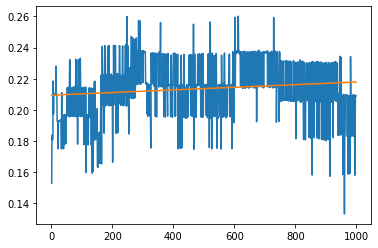

In [126]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type ips -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0',
         'npol': 1,
         'maxdata': 100000,
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.18333  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.18333  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.24875  	0.24135  
32    	561     	0.05704	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.66101  	0.44103  
64    	1626    	0.03936	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.97301  	0.30179  
128   	3335    	0.03838	[-0.02344,-0.02344,-0.02344]	[-0.02344,-0.02344,-0.02344]	0.22180  	0.46290  
256   	6857    	0.03733	[-0.02734,-0.02734,-0.02734]	[-0.02734,-0.02734,-0.02734]	0.92315  	0.56164  
512 

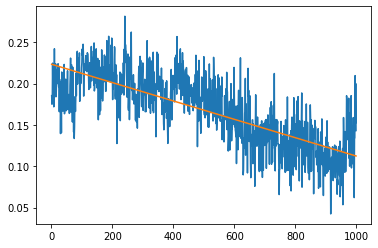

In [127]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --softmax --epsilon 0.025 --lambda 160 --dsjson -q RA -q PA --cb_type mtr -l 0.1 --l1 1e-06 --power_t 0',
         'npol': 1,
         'maxdata': 100000,
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16835  	0.16835  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.21264  	0.21264  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.15546  	0.18019  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.19956  	0.17837  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.22811  	0.24957  
32    	641     	0.04992	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.29947  	0.51546  
64    	3598    	0.01779	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.99200  	0.70418  
128   	10557   	0.01212	[-0.01562,-0.01562,-0.01562]	[-0.01562,-0.01562,-0.01562]	0.99200  	0.87777  
256   	29542   	0.00867	[-0.01953,-0.01953,-0.01953]	[-0.01953,-0.01953,-0.01953]	0.99200  	0.96693  
512 

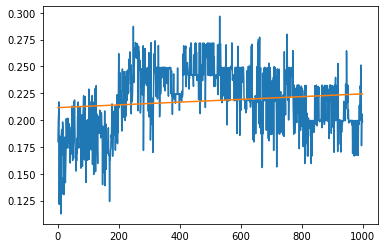

In [125]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '-b 19 --cb_explore_adf --epsilon 0.01 --rnd 1 --rnd_alpha 1e-12 --rnd_invlambda 1e-5 --dsjson --cb_type mtr -q RA -q PA -l 5e-1 --power_t 0',
         'npol': 1,
         'maxdata': 100000,
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.18333  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.18333  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.24000  	0.23917  
32    	587     	0.05451	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.04000  	0.57250  
64    	1390    	0.04604	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.84000  	0.66667  
128   	2813    	0.04550	[-0.02344,-0.02344,-0.02344]	[-0.02344,-0.02344,-0.02344]	0.84000  	0.69896  
256   	5763    	0.04442	[-0.01953,-0.01953,-0.01953]	[-0.01953,-0.01953,-0.01953]	0.83333  	0.71820  
512 

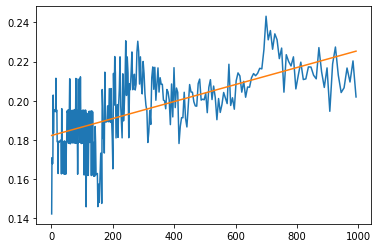

In [176]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type ips -q RA -q PA -l 0.0001 --l1 1e-06 --power_t 0',
         'npol': 1,
         'maxdata': 500000,
         'kvlimit': 1000
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.20000  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16667  	0.18333  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.20000  	0.18333  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.24875  	0.24135  
32    	561     	0.05704	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.66101  	0.44103  
64    	1626    	0.03936	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.97301  	0.30179  
128   	3335    	0.03838	[-0.02344,-0.02344,-0.02344]	[-0.02344,-0.02344,-0.02344]	0.22180  	0.46290  
256   	6857    	0.03733	[-0.02734,-0.02734,-0.02734]	[-0.02734,-0.02734,-0.02734]	0.92315  	0.56164  
512 

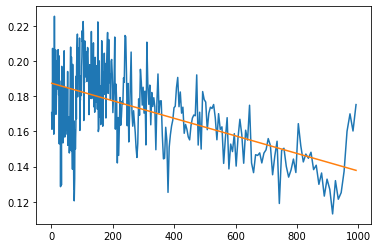

In [177]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '--cb_explore_adf --softmax --epsilon 0.025 --lambda 160 --dsjson -q RA -q PA --cb_type mtr -l 0.1 --l1 1e-06 --power_t 0',
         'npol': 1,
         'maxdata': 500000,
         'kvlimit': 1000
       })

n     	n raw   	accept	cost                     	since last               	pi[a]    	since last pi[a]
1     	60      	0.01667	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.16835  	0.16835  
2     	72      	0.02778	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.21264  	0.21264  
4     	87      	0.04598	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.15546  	0.18019  
8     	185     	0.04324	[0.00000,0.00000,0.00000]	[0.00000,0.00000,0.00000]	0.19956  	0.17837  
16    	269     	0.05948	[-0.06250,-0.06250,-0.06250]	[-0.06250,-0.06250,-0.06250]	0.22811  	0.24957  
32    	641     	0.04992	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.29947  	0.51546  
64    	3598    	0.01779	[-0.03125,-0.03125,-0.03125]	[-0.03125,-0.03125,-0.03125]	0.99200  	0.70418  
128   	10557   	0.01212	[-0.01562,-0.01562,-0.01562]	[-0.01562,-0.01562,-0.01562]	0.99200  	0.87777  
256   	29542   	0.00867	[-0.01953,-0.01953,-0.01953]	[-0.01953,-0.01953,-0.01953]	0.99200  	0.96693  
512 

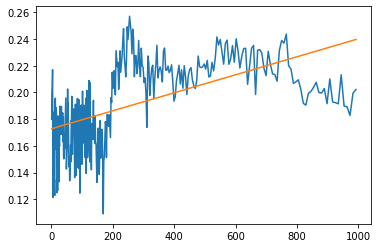

In [178]:
dontforkit(evalitcreative, (),
       kwds = {
         'path' : '/mnt/c/Users/pmineiro/Downloads/iris/', 
         'seed' : 4545,
         'maxratio' : 1/(0.2/5),
         'veedub' : '-b 19 --cb_explore_adf --epsilon 0.01 --rnd 1 --rnd_alpha 1e-12 --rnd_invlambda 1e-5 --dsjson --cb_type mtr -q RA -q PA -l 5e-1 --power_t 0',
         'npol': 1,
         'maxdata': 500000,
         'kvlimit': 1000
       })